In [198]:
import numpy as np
import matplotlib.pyplot as plt





Generating Random Data

```
     Numpy and Random Seed: Importing NumPy and setting a seed for random number generation
```



In [199]:
rnd = np.random
rnd.seed(0)

In [200]:
n = 10  # numbre of clients
xc = rnd.rand(n+1)*200
yc = rnd.rand(n+1)*100

Defining Variables:



```
n: Number of clients.

xc and yc: Randomly generated coordinates for the clients.

N, V, A: Lists representing nodes, vertices, and arcs for the problem.

c: Dictionary containing distances between nodes, which is taken as cost to travel between nodes.

Q, v_vehicle, v_orders, shapes, q: Variables related to vehicle capacity, volumes, and shapes.
```



In [201]:
N = [i for i in range(1, n+1)]
V = [0] + N
A = [(i, j) for i in V for j in V if i != j]
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
Q = 20
v_vehicle = 30  # Volume capacity of the vehicle
v_orders = {i: rnd.randint(5, 15) for i in N}  # Volume of orders for each customer
shapes={i:rnd.randint(0,2)for i in N} #shape of container
q = {i: rnd.randint(1, 10) for i in N}

In [202]:
shapes

{1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0}

In [203]:
v_orders

{1: 8, 2: 8, 3: 8, 4: 12, 5: 5, 6: 6, 7: 14, 8: 14, 9: 5, 10: 9}


Plotting Clients and Depot:
```
Scatter plot for client coordinates (xc, yc) with blue color and annotations.
Plotting the depot with a red square marker and annotation.
```



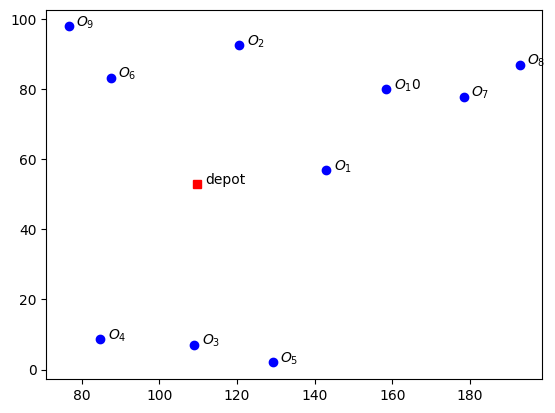

In [204]:
plt.scatter(xc[1:], yc[1:], c='b')
for i in N:
    plt.annotate('$O_%d$' % (i),(xc[i]+2,yc[i]))
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.annotate('depot' ,(xc[0]+2,yc[0]))
precedence_constraints = [1,7,9]


### Model Initialization using Gurobi

Installing Gurobi:
```
If Gurobi is not installed, it installs it using !pip install gurobipy.
```



In [205]:
!pip install gurobipy

In [206]:
from gurobipy import Model, GRB, quicksum

In [207]:
mdl = Model('CVRP')




####  Decision variables (x, u, p, v) are defined for the model.




In [208]:
x = mdl.addVars(A, vtype=GRB.BINARY)
u = mdl.addVars(N, vtype=GRB.CONTINUOUS)
p = mdl.addVars(N, vtype=GRB.CONTINUOUS)
v = mdl.addVars(N, vtype=GRB.CONTINUOUS, lb=0)

#### Void Volume Calculation

In [209]:
# Calculate the void volume for spheres
void_volume = {i: 0 for i in N}
for i in N:
    if shapes[i] == 1:  # Sphere
        # Calculate void volume for spheres assuming sphere_volume is known
        sphere_volume = v_orders[i]
        sphere_radius = ((3 * sphere_volume) / (4 * np.pi)) ** (1/3)
        cube_side = 2 * sphere_radius  # Side of the enclosing cube
        void_volume[i] = cube_side ** 3 - sphere_volume  # Void volume

### Objective Function and Constraints






```
Sets the objective function to minimize the total cost considering distances and penalty terms.
```



In [210]:
penalty_coefficient = 2
mdl.setObjective(
    quicksum(c[i, j] * x[i, j] for i, j in A) +
    penalty_coefficient * quicksum(void_volume[j] * x[i, j] for i, j in A if j!=0 and  shapes[j] == 1),
    GRB.MINIMIZE
)


#### Adding Constraints:

Constraints ensure each node is visited exactly once, vehicle capacity and volume constraints are satisfied, and precedence constraints are applied.




In [211]:
mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)  # Binary variables for precedence order

mdl.addConstrs((x[i, j] == 1) >> (u[i] + q[j] == u[j]) for i, j in A if i != 0 and j != 0)
mdl.addConstrs(u[i] >= q[i] for i in N)
mdl.addConstrs(u[j] <= Q for j in N)

for i in range(len(precedence_constraints) - 1):
    mdl.addConstr(x[precedence_constraints[i], precedence_constraints[i + 1]] == 1)
    mdl.addConstr(u[precedence_constraints[i]]<= u[precedence_constraints[i+1]])

for i, j in A:
    if i != 0 and j != 0:
        mdl.addConstr(v[i] + v_orders[j] + void_volume[j]<= v_vehicle)  # Volume constraint for each route
mdl.addConstrs(v[i] >= 0 for i in N)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>}

###Optimization

Optimization Parameters and Solving the Model:
Optimization parameters are set, and the model is solved.
Active arcs (selected routes) are identified based on the solver results.

In [212]:
mdl.Params.MIPGap = 0.1
mdl.Params.TimeLimit = 500  # seconds
mdl.optimize()

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 500
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 144 rows, 140 columns and 326 nonzeros
Model fingerprint: 0xe66594e1
Model has 90 general constraints
Variable types: 30 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
  GenCon rhs range [2e+00, 9e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 31 rows and 71 columns
Presolve time: 0.01s
Presolved: 113 rows, 69 columns, 399 nonzeros
Variable types: 25 continuous, 44 integer (44 binary)
Found heuristic solution: objective 1046.0713689
Found heuristic solution: objective 935.8790771
Found heuristic solution: ob

In [213]:
active_arcs = [a for a in A if x[a].x > 0.99]

In [214]:
active_arcs

[(0, 1),
 (0, 3),
 (0, 4),
 (0, 10),
 (1, 7),
 (2, 6),
 (3, 5),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 9),
 (8, 2),
 (9, 0),
 (10, 8)]

### Plotting Active Arcs

Arrows between connected nodes are plotted based on active arcs found in the optimization.
Annotations with arrow indices are added.

Text(111.76270078546494, 52.88949197529045, 'depot')

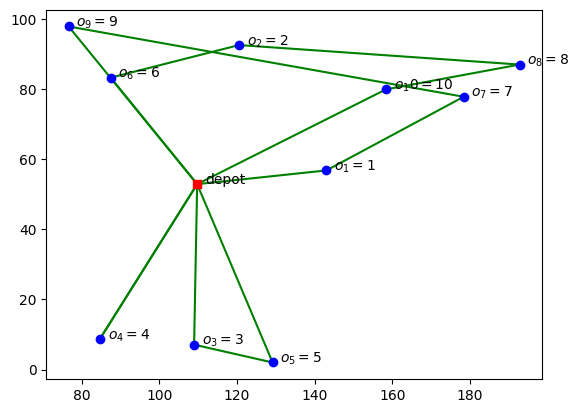

In [215]:
for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
plt.scatter(xc[1:], yc[1:], c='b')
for i in N:
    plt.annotate('$o_%d=%d$' % (i, i),(xc[i]+2,yc[i]))
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.annotate('depot' ,(xc[0]+2,yc[0]))

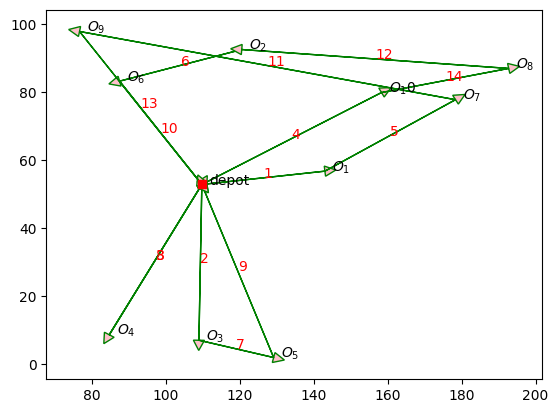

In [216]:
plt.scatter(xc[1:], yc[1:], c='white')
for i in N:
    plt.annotate('$O_%d$' % (i), (xc[i]+2, yc[i]))
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.annotate('depot', (xc[0]+2, yc[0]))

for idx, (i, j) in enumerate(active_arcs):
        dx = xc[j] - xc[i]
        dy = yc[j] - yc[i]
        plt.arrow(xc[i], yc[i], dx, dy, head_width=3, head_length=3, fc='pink', ec='g')
        plt.annotate(str(idx + 1), ((xc[i] + xc[j]) / 2, (yc[i] + yc[j]) / 2), color='red')

plt.show()